<a href="https://colab.research.google.com/github/adamsyed3181/GenAI/blob/main/Module1/LLM_Text_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install & import the needed libraries

!pip install -q transformers torch

!pip install triton torchao



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.3/188.3 MB 6.6 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import os
os.environ["TQDM_DISABLE"] = "1" # Disables progress bar widgets error caused by GPT


In [3]:
# Load tokenizer & model

tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
model = GPT2LMHeadModel.from_pretrained("distilgpt2")
model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

Prompt: “A man lived under a bridge”

In [4]:
# Enter your own input text

text = input("Enter a sentence: ")


Enter a sentence: A man lived under a bridge


In [5]:
# The tokenization step typically creates subword tokens, and not necessarily whole words

tokens = tokenizer.encode(text, return_tensors="pt")

print("Token IDs:", tokens.tolist()[0])
print("Tokens:")
for tid in tokens[0]:
    print(f"{tid.item():>6} → '{tokenizer.decode(tid)}'")


Token IDs: [32, 582, 5615, 739, 257, 7696]
Tokens:
    32 → 'A'
   582 → ' man'
  5615 → ' lived'
   739 → ' under'
   257 → ' a'
  7696 → ' bridge'


In [6]:
# The embeddings

with torch.no_grad():
    # Token embeddings
    token_embeds = model.transformer.wte(tokens)

    # Positional embeddings
    positions = torch.arange(tokens.size(1)).unsqueeze(0)
    pos_embeds = model.transformer.wpe(positions)

    embeddings = token_embeds + pos_embeds

# (batch_size, sequence_length, embedding_dim)
print("Embedding shape:", embeddings.shape)


Embedding shape: torch.Size([1, 6, 768])


In [7]:
# The transformer forward pass ensures that each token now contains contextual information from previous tokens.
# This is the most important step conceptually, because this is where the model goes from isolated words to understanding a sentence.

with torch.no_grad():

    # Send the embedding vectors through all transformer layers (for GPT-2, it is 12 layers)
    outputs = model.transformer(inputs_embeds=embeddings)

    # Each layer, applies the self-attention mechanism and goes through a feed-forward NN
    hidden_states = outputs.last_hidden_state

print("Hidden state shape:", hidden_states.shape)


Hidden state shape: torch.Size([1, 6, 768])


In [8]:
# Logits for the next token. This gives one score per vocabulary token (~50k tokens)

with torch.no_grad():
    last_hidden = hidden_states[:, -1, :]
    logits = model.lm_head(last_hidden)

print("Logits shape:", logits.shape)


Logits shape: torch.Size([1, 50257])


In [9]:
# Softmax → probabilities: this is the actual probability distribution the model uses

probs = F.softmax(logits, dim=-1)

top_probs, top_ids = torch.topk(probs, k=10)

print("Top 10 next-token probabilities:")
for p, tid in zip(top_probs[0], top_ids[0]):
    token = tokenizer.decode(tid)
    print(f"{token!r:>12} : {p.item():.4f}")


Top 10 next-token probabilities:
       ' in' : 0.1666
         '.' : 0.0962
         ',' : 0.0828
      ' and' : 0.0631
      ' for' : 0.0451
       ' at' : 0.0407
     ' with' : 0.0315
       ' on' : 0.0310
  ' between' : 0.0282
     ' that' : 0.0236


In [10]:
# Sampling (temperature + top-k)

#    temperature = 0.2 (Set a low temperature value to generate predictable responses)
#    temperature = 1.5 (Set a high temperature value to generate more random and creative responses)
#    top_k = None (full distribution)

def sample_next_token(logits, temperature=1.2, top_k=50):
    logits = logits / temperature

    if top_k is not None:
        values, indices = torch.topk(logits, top_k)
        probs = F.softmax(values, dim=-1)
        choice = torch.multinomial(probs, 1)
        return indices[0, choice]
    else:
        probs = F.softmax(logits, dim=-1)
        return torch.multinomial(probs, 1)

next_token_id = sample_next_token(logits, temperature=0.8, top_k=40)
print("Sampled token:", tokenizer.decode(next_token_id[0]))


Sampled token:  in


In [15]:
# Full loop (generate multiple tokens)

def generate_step_by_step(prompt, steps=10):
    tokens = tokenizer.encode(prompt, return_tensors="pt")

    for _ in range(steps):
        with torch.no_grad():
            outputs = model(tokens)
            logits = outputs.logits[:, -1, :]
            next_token = sample_next_token(logits, temperature=0.8, top_k=40)

        tokens = torch.cat([tokens, next_token], dim=1)
        print(tokenizer.decode(tokens[0]))

generate_step_by_step(text, steps=20)


A man lived under a bridge in
A man lived under a bridge in B
A man lived under a bridge in Borne
A man lived under a bridge in Borneo
A man lived under a bridge in Borneo,
A man lived under a bridge in Borneo, Indonesia
A man lived under a bridge in Borneo, Indonesia in
A man lived under a bridge in Borneo, Indonesia in the
A man lived under a bridge in Borneo, Indonesia in the late
A man lived under a bridge in Borneo, Indonesia in the late 1990
A man lived under a bridge in Borneo, Indonesia in the late 1990s
A man lived under a bridge in Borneo, Indonesia in the late 1990s.
A man lived under a bridge in Borneo, Indonesia in the late 1990s.

A man lived under a bridge in Borneo, Indonesia in the late 1990s.


A man lived under a bridge in Borneo, Indonesia in the late 1990s.



A man lived under a bridge in Borneo, Indonesia in the late 1990s.




A man lived under a bridge in Borneo, Indonesia in the late 1990s.





A man lived under a bridge in Borneo, Indonesia in the late 1990s

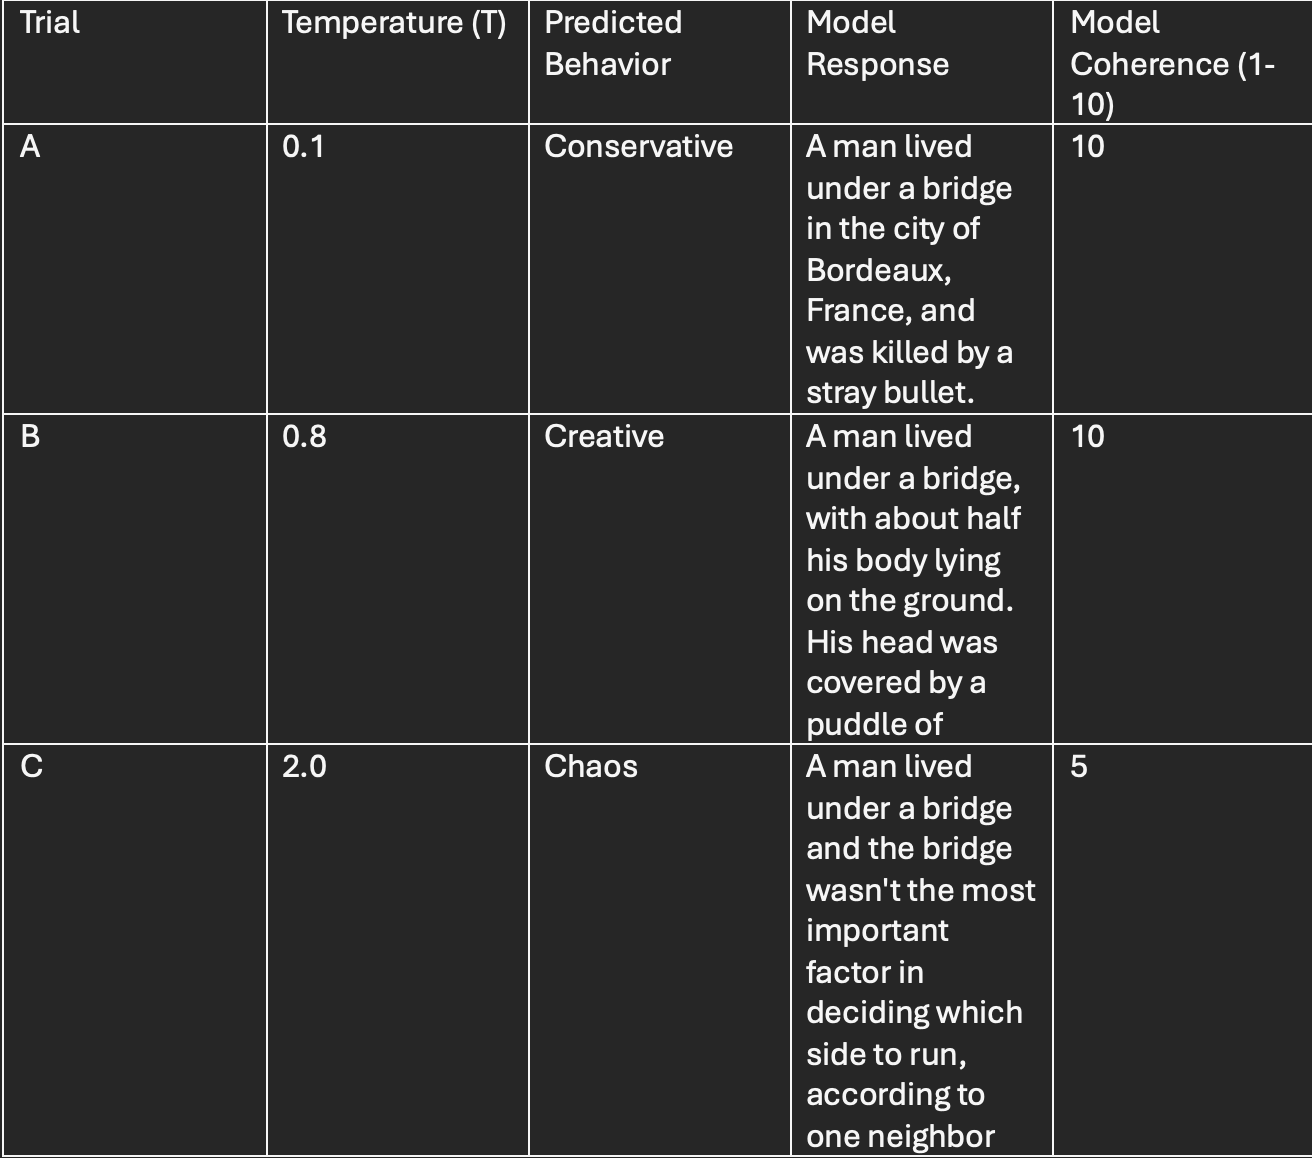

**Analysis**
---
**Prompt: A man lived under a bridge**


*   Model did not repeat any words or phrases, but for responses 0.1 and 0.8 it chose a rather dark vibe to my prompt, describing “the man” as either “killed” or dismembered.
*   The model only used real words. Though if it did, it is most likely because higher temperatures tend to choose tokens with varying ranges of probabilities. From the “Probability Distribution”, high temperatures will not act greedy and chose the highest probability for every token but will sometimes choose tokens with low probabilities resulting in random characters and punctuations. A generation like this will output total gibberish.
*  For a medical AI, I would choose to use a conservative temperature between 0.1-0.2. Medical responses should be highly precise and should have little to no creativity in its responses. This would ensure the output is accurate and not “fluffed up” with unimportant text.
*   If I was using AI to write a surrealist dream-journal, I would use a creative temperature between 0.8-0.9 to ensure creativity in my responses. A temperature at this magnitude would keep its grammatical structure but would take creative leaps in its output.

---
**Extra Credit**

---



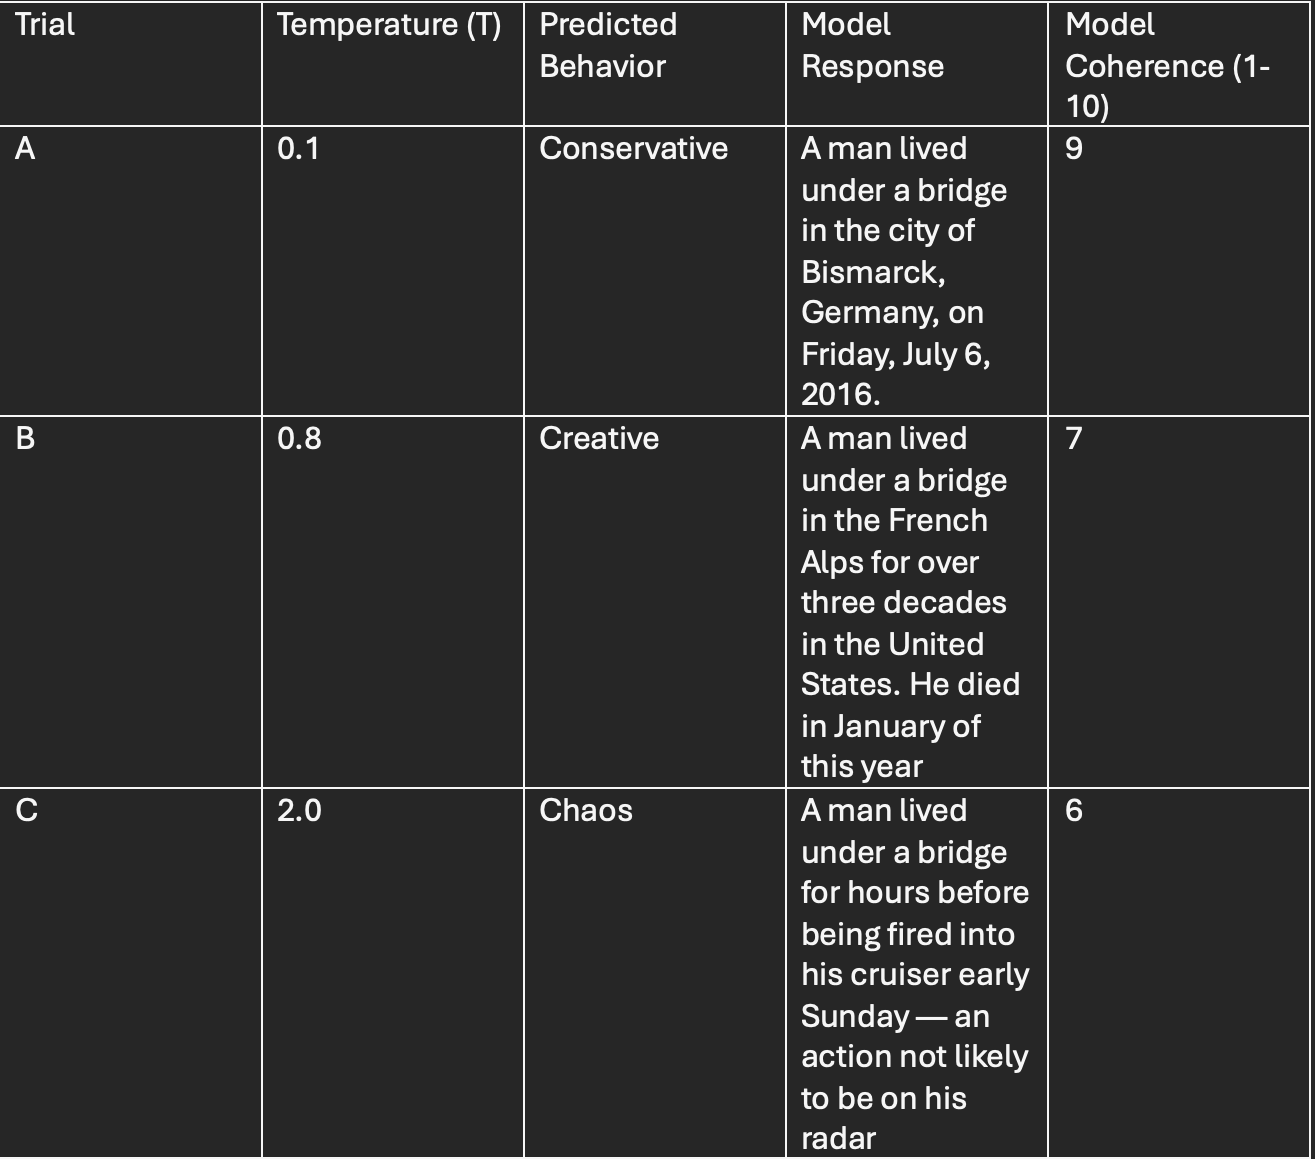

**Analysis**

---


Using the distilgpt2 displayed varying results compared to the gpt2 model. Using a temperature of 0.1 generated a cohesive response but included odds specifics such as the exact location and date. Using a creative temperature, 0.8, resulted in inconsistencies in the generation – saying the man that the bridge was in the “French Alps” but also in the “United States”. These errors continued in the chaotic temperature, 0.2, where the generation had logical leaps. Overall, the distil model resulted in comprehensive text generations that are comparable to the gpt2 model, though I would classify the gpt2 model as “more intelligent”. gpt2 was able to string together more engaging and creative responses, even using lower temperatures, and did not suffer from any factual errors in higher temperatures.
